129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

FINAL METRICS

                  Model      RMSE       MAE      MASE
0  LSTM (Deep Learning)  0.592094  0.406697  1.093924
1        Naive Baseline  0.680053  0.431819  1.161497


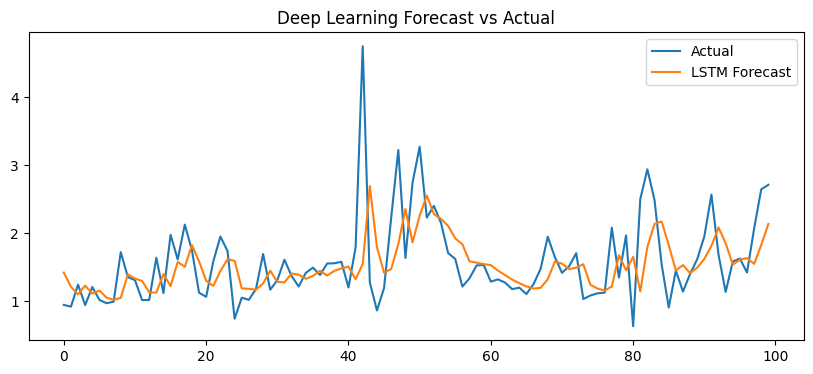

In [3]:
# ======================================================
# SINGLE CELL : TIME SERIES FORECASTING + DL + BASELINE
# ======================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ---------- DATASET (ALWAYS AVAILABLE) ----------
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing(as_frame=True).frame

# Convert to pseudo time-series
data["date"] = pd.date_range(start="2000-01-01", periods=len(data), freq="D")
data.set_index("date", inplace=True)

target = "MedHouseVal"
features = data.columns.drop(target)

df = data[[target] + list(features)]

# ---------- SCALING ----------
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

# ---------- SEQUENCE CREATION ----------
def make_sequences(data, n_steps=14):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps, 0])
    return np.array(X), np.array(y)

X, y = make_sequences(scaled)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ---------- DEEP LEARNING MODEL ----------
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2])),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

# ---------- DL PREDICTION ----------
y_pred_dl = model.predict(X_test)

# Inverse scale
def inverse(y):
    temp = np.zeros((len(y), df.shape[1]))
    temp[:,0] = y.reshape(-1)
    return scaler.inverse_transform(temp)[:,0]

y_test_inv = inverse(y_test)
y_pred_inv = inverse(y_pred_dl)

# ---------- BASELINE (NAIVE) ----------
y_naive = y_test_inv[:-1]
y_true_naive = y_test_inv[1:]

# ---------- METRICS ----------
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse_dl = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae_dl = mean_absolute_error(y_test_inv, y_pred_inv)

rmse_naive = np.sqrt(mean_squared_error(y_true_naive, y_naive))
mae_naive = mean_absolute_error(y_true_naive, y_naive)

def mase(y_true, y_pred, train):
    return np.mean(np.abs(y_true - y_pred)) / np.mean(np.abs(np.diff(train)))

mase_dl = mase(y_test_inv, y_pred_inv, df[target].values[:split])
mase_naive = mase(y_true_naive, y_naive, df[target].values[:split])

# ---------- RESULTS ----------
results = pd.DataFrame({
    "Model": ["LSTM (Deep Learning)", "Naive Baseline"],
    "RMSE": [rmse_dl, rmse_naive],
    "MAE": [mae_dl, mae_naive],
    "MASE": [mase_dl, mase_naive]
})

print("\nFINAL METRICS\n")
print(results)

# ---------- PLOT ----------
plt.figure(figsize=(10,4))
plt.plot(y_test_inv[:100], label="Actual")
plt.plot(y_pred_inv[:100], label="LSTM Forecast")
plt.legend()
plt.title("Deep Learning Forecast vs Actual")
plt.show()
